#### (Home credit competition 중심으로)
## 2.3 데이터 정제 - 데이터간 관계를 중심으로

---
### 소스 및 데이터는 아래 kaggle을 참조하였습니다. 
* 캐글 주소 : https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
* 캐글의 한글 번역은 파파고와 구글을 이용하였습니다.
___

In [1]:
# 라이브러리 

import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [2]:
# 데이터 셋
app_train = pd.read_csv('d:/Projects/Cp/input/application_train.csv')
app_test = pd.read_csv('d:/Projects/Cp/input/application_test.csv')

In [3]:
#  레이블 인코딩 
le = LabelEncoder()
le_count = 0

for col in app_train:    
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2: 
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col]  = le.transform(app_test [col])            
            le_count += 1

In [4]:
# 원 핫 인코딩
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [5]:
# 원 핫 인코딩 후 훈련/테스트 용 데이터 열(컬럼) 일치화

# TARGET(대출금 상환여부)열 따로 보관
train_labels = app_train['TARGET']

# 열(컬럼)기준 데이터 정렬하여 서로 없는 열(컬럼) 삭제
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# 학습용 데이터에 TARGET(대출금 상환여부)열 추가
app_train['TARGET'] = train_labels

In [6]:
# 취업일(DAYS_EMPLOYED) 이상치 데이터 처리

# 훈련용 셋
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 테스트용 셋
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

#### 상관(Correlations)
* 데이터를 이해하는 한가지 방법은 특징(feature)과 대상 간의 상관 관계를 찾는 것이다
* .corr 데이터프레임 메소드를 사용하여 모든 변수와 대상 간의 피어슨(Pearson) 상관 계수를 계산할 수 있다.
* 상관 계수는 특징(feature)의 "관련성"을 표현하는 가장 좋은 방법은 아니지만 데이터 내에서 가능한 관계에 대한 아이디어를 제공합니다. 
---
*상관 계수의 절대 값에 대한 일반적인 해석은 다음과 같습니다.

> * .00-.19  : 매우 약함
> * .20-.39  : 약한
> * .40-.59  : 보통
> * .60 - .79: 강한
> * .80-1.0  : 매우 강한

In [7]:
# 대상과 상관 관계를 찾기 및 정렬
correlations = app_train.corr()['TARGET'].sort_values(ascending=False)

# 상관관계 표시
print('\nMost Negative Correlations:\n', correlations.head(15))
print('Most Positive Correlations:\n', correlations.tail(15))



Most Negative Correlations:
 TARGET                                               1.000000
DAYS_BIRTH                                           0.078239
DAYS_EMPLOYED                                        0.074958
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
DAYS_LAST_PHONE_CHANGE                               0.055218
CODE_GENDER_M                                        0.054713
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
FLAG_EMP_PHONE                                       0.045982
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_DOCUMENT_3                                      0.044346
OCCUPATION_TYPE_Laborers                             0.043019
Name: TARGET, dtype: float64
Most Positi

#### 상관관계 살펴보기
* Target(대출상환여부)과 가장 긍정적인 변수는 DAYS_BIRTH입니다. (동일 변수와 상관관계는 항상 1이기 때문에 Target vs Target은 제외한다.)
* DAYS_BIRTH는 대출 시점의 고객 연령입니다. 상관관계는 긍정적이지만 DAYS_BIRTH의 실제 값은 음수입니다. 
* 즉, 대출신청자는 나이가 들수록 대출 채무불이행 가능성이 줄어듭니다.
* Target(대출상환여부) = 0 => 0 - 상환, 1 - 미상환

#### 대출 상환에 대한 연령의 영향
* 생년월일(DAYS_BIRTH) 및 대출상환여부(TARGET)의 상관관계 찾기
* 편의를 위해 DAYS_BIRTH의 절대값을 취하여 양수를 만듭니다. 대신 상관관계는 음수가 됩니다.

In [8]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

* 대출신청자는 나이가 들면서 대출상환여부(TARGET)와 음의 선형관계가 형성됩니다.
* 즉 대출신청자의 나이를 먹으면 자주 대출금을 상환하는 경향이 있습니다.
  양의 관계라면 대출상환여부(TARGET)가 1, 미상환이 증가한다는 뜻입니다.    

* 막대그래프를 만들어본다.

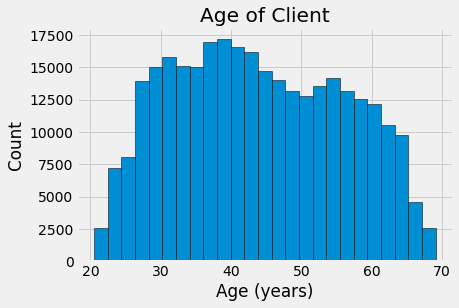

In [9]:
plt.style.use('fivethirtyeight')

# 연중 연령별 분포
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

* 연령 분포 그래프는 특이치가 없다는 것 외에 다른 내용은 없습니다.
* 연령이 대상에 미치는 영향을 시각화하기 위해 목표값별로 색칠된 커널 밀도 추정치(KDE)를 작성합니다. 
* 커널 밀도 추정치는 단일 변수의 분포를 나타내며 매끄러운 히스토그램으로 생각할 수 있습니다
> 일반적으로 각 데이터 포인트에서 커널, 일반적으로 가우스 곡선을 계산한 다음 모든 개별 평활 커널을 평균하여 생성됨. 
* 이 그래프에는 seaborn Kdevilot를 사용할 것이다.

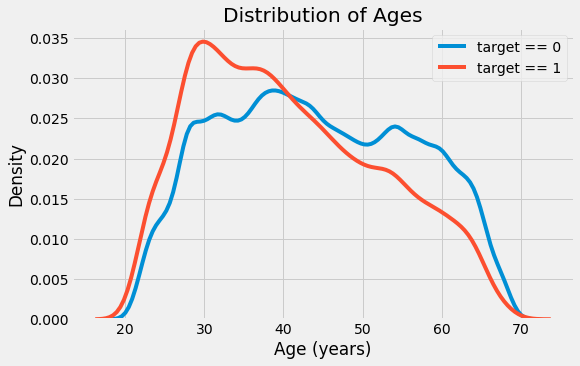

In [10]:
plt.figure(figsize = (8, 5))
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0') # 제때 상환된 대출의 KDE 그래프
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1') # 제때 상환되지 않은 대출의 KDE 그래프
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

* target - 0 : 대출금 상환, 1 : 대출금 미상환
---

#### 왜도(skewness)와 첨도(kurtosis)

* 왜도
    * 자료의 분포모양이 평균을 중심으로 한 쪽으로 치우쳐져 있는 경향을 나타내는 척도.
    * 확률분포곡선에서 비대칭의 정도를 나타내는 측도.
    > a = 0 정규분포    
    > a > 0 좌측으로 치우침    
    > a < 0 우측으로 치우팀

* 첨도
    * 자료의 분포모양이 정규분포보다 더 중앙에 집중하는가를 나타내는 척도.
    > a = 3 정규분포    
    > a > 3 뾰쪽함    
    > a < 3 평평함
    
* 자료 출처 : http://blog.daum.net/_blog/BlogTypeView.do?blogid=0ElQz&articleno=12361858

___
* 미상환 대출금 (target == 1) 그래프를 보면 왜도가 좌측(상대적으로 젊은 연령대)으로 치우쳐 있다.  
* 이 변수는 유의한 상관관계(0.07 상관 계수)는 아니지만 대상에 영향을 미치기 때문에 기계학습 모델에서 유용할 수 있다. 
---
+ 이 관계를(평균적인 미상환 대출금) 또 다른 시각으로 보자 
    + 해당 그래프를 만들려면 먼저 연령 카테고리를 각각 5년 단위로 나눕니다.
    + 그런 다음 각 대상의 구간별 평균값을 계산 합니다.
    + 이는 각 연령 구간별 상환되지 않은 대출 비율을 알려 줍니다.

In [11]:
# 연령대 정보를 다른 데이터프레임에 저장하고 년으로 환산
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# 나이 구간 설정
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


* 참고 : ( X, Y ] : X 이상 Y 미만, 즉 X <= Z < Y 구간을 의미함

In [12]:
# 미상환 대출에 대해 나이 구간별 기준으로 그룹화하여 평균 계산
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


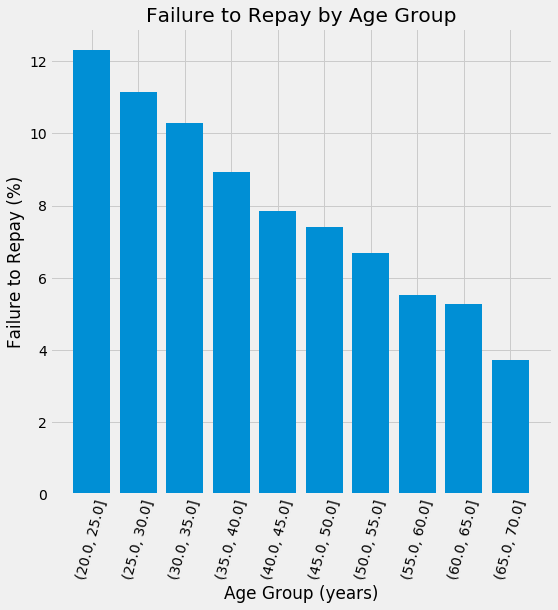

In [13]:
# 연령 구간별 미상한 대출 평균을 막대그래프로 표시
plt.figure(figsize = (8, 8))

plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

* 분명한 추세
    * 젊은 대출 신청자는 미상환 가능성이 크다
    * 젊은 세 그룹의 경우 미상환 율이 10% 이상이다
    * 가장 나이 많은 그룹의 미상환 율은 5% 미만이다
---
* 이것은 은행이 직접 사용할 수 있는 정보이다.
    * 젊은 대출 신청자는 대출금 상환 가능성이 낮기 때문에 더 많은 지침이나 재정계획 정보를 제공해야 한다.
    * 은행은 더 젊은 대출 신청자을 차별해야한다는 것을 의미하지는 않지만 젊은 고객들이 제때 상환하는 것을 돕기 위해 사전예방 조치를 취하는 것이 현명할 것이다.